PFR volume to reach 90% overall conversion: V90 = 756.3942712494437 L  (≈ 0.7563942712494437 m^3)


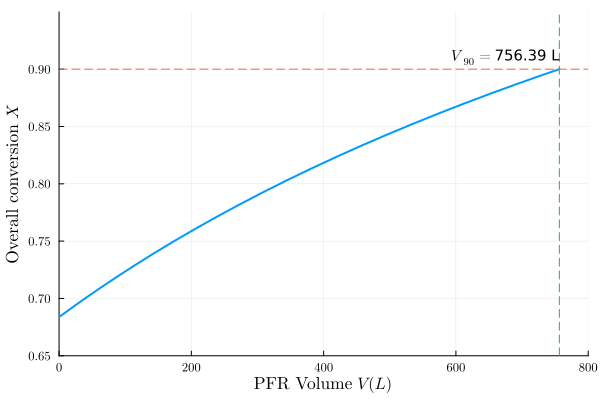

In [19]:
using DifferentialEquations
using Plots, LaTeXStrings

# ----------------------------
# Parameters (given)
# ----------------------------
k1   = 2.0e-4   # mol L^-1 s^-1
k2   = 1.5e-3   # s^-1
k3   = 8.0e-3   # L mol^-1 s^-1
vdot = 3.0      # L s^-1  (volumetric flow rate)

CA0      = 0.5                          # mol/L (fresh feed concentration, for overall conversion)
CA_in_PFR = sqrt(0.025)                  # mol/L (CSTR outlet when maximizing S_P ≈ 0.158113883...)

# Target: 90% overall conversion relative to CA0 => CA = 0.1*CA0
CA_target = 0.10 * CA0                   # mol/L = 0.05

# ----------------------------
# ODE: dCA/dV = -(k1 + k2*CA + k3*CA^2)/vdot
# Independent variable is reactor volume V (L)
# ----------------------------
function dCAdV!(dCA, CA, p, V)
    dCA[1] = -(k1 + k2*CA[1] + k3*CA[1]^2) / vdot
end

u0 = [CA_in_PFR]     # initial condition at V=0
Vspan = (0.0, 5000.0) # integrate up to 5000 L unless we terminate earlier

# Stop integration when CA reaches CA_target (i.e., 90% overall conversion)
condition(CA, V, integrator) = CA[1] - CA_target
affect!(integrator) = terminate!(integrator)
cb = ContinuousCallback(condition, affect!; rootfind=true)

prob = ODEProblem(dCAdV!, u0, Vspan)
sol  = solve(prob, Tsit5(); callback=cb, reltol=1e-10, abstol=1e-12)

# Volume needed for 90% overall conversion
V90 = sol.t[end]  # (L) because we terminated right at CA_target

# Build arrays for plotting conversion vs volume (overall conversion relative to CA0)
Vvals = sol.t
CAvals = [u[1] for u in sol.u]
Xvals = (CA0 .- CAvals) ./ CA0

println("PFR volume to reach 90% overall conversion: V90 = $(V90) L  (≈ $(V90/1000) m^3)")

# Plot
plot(Vvals, Xvals, fontfamily="Computer Modern",
     xlabel="PFR Volume "*L"V \, (L)",
     ylabel="Overall conversion "* L"X",
     lw=2,
     legend=false,
     xlims=(0, 800),
     ylims=(0.65, 0.95))
hline!([0.9], ls=:dash)
vline!([V90], ls=:dash)
annotate!(V90, 0.91, text(L"V_{90} = "*"$(round(V90, digits=2)) L", :right, 10))
savefig("figs/PFR_Conversion_vs_Volume.pdf")
display(current())
